In [1]:
import carla 
import math 
import random 
import time 
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Connect the client and set up bp library and spawn points
client = carla.Client('localhost', 2000) 
world = client.get_world()
bp_lib = world.get_blueprint_library()  
spawn_points = world.get_map().get_spawn_points() 

In [2]:
import sys 
import os

In [3]:
dir_paths = ['CARLA_0.9.13\\WindowsNoEditor\\PythonAPI\\carla', 'scenario_runner']
sys.path += [os.path.join(os.getcwd(), dir_path) for dir_path in dir_paths]

In [4]:
for v in world.get_actors().filter('*vehicle*'):
    v.destroy()
for s in world.get_actors().filter('*sensor*'):
    s.destroy()

In [5]:
from agents.navigation.global_route_planner import GlobalRoutePlanner
from srunner.tools.scenario_helper import get_waypoint_in_distance
from agents.navigation.local_planner import RoadOption
from srunner.tools.route_manipulation import interpolate_trajectory
from srunner.scenariomanager.carla_data_provider import CarlaDataProvider

In [6]:
# Spawn ego vehicle
vehicle_bp = bp_lib.find('vehicle.tesla.model3') 
vehicle = world.try_spawn_actor(vehicle_bp, random.choice(spawn_points))

# Move spectator behind vehicle to view
spectator = world.get_spectator() 
transform = carla.Transform(vehicle.get_transform().transform(carla.Location(x=-4,z=2.5)),vehicle.get_transform().rotation) 
spectator.set_transform(transform)

In [10]:
world = client.load_world('Town01_Opt')

In [85]:
start_point, end_point = random.choice(spawn_points), random.choice(spawn_points)

In [146]:
vehicle.set_location(vehicle.get_location() + carla.Location(y=10))

In [8]:
vehicle_loc = vehicle.get_location()
vehicle_loc.x, vehicle_loc.y, vehicle_loc.z

(176.58950805664062, 133.23915100097656, 0.0017469978192821145)

In [9]:
c_map = world.get_map()

In [10]:
start_waypoint = c_map.get_waypoint(vehicle_loc)

In [11]:
end_waypoint, dist_travelled = get_waypoint_in_distance(start_waypoint, 200)

In [86]:
vertical_shift = .5
persistency = 10
world.debug.draw_point(vehicle_loc + carla.Location(z=vertical_shift), size=0.3,
                               color=carla.Color(0, 0, 255), life_time=persistency)
world.debug.draw_point(end_point.location + carla.Location(z=vertical_shift), size=0.3,
                               color=carla.Color(255, 0, 0), life_time=persistency)
world.debug.draw_point(end_waypoint.transform.location + carla.Location(z=vertical_shift), size=0.3,
                                color=carla.Color(255, 0, 0), life_time=persistency)

In [12]:
def get_trajectory_from_route(route):
    trajectory = []
    for waypoint, route_marking in route:
        loc = waypoint.transform.location
        trajectory.append(loc)
    return trajectory

In [14]:
CarlaDataProvider.set_client(client)
CarlaDataProvider.set_world(world)

In [82]:
def get_routes(vehicle_loc, end_location, hop_resolution=1.0):    
    # grp = GlobalRoutePlanner(CarlaDataProvider.get_map(), hop_resolution)
    # route = grp.trace_route(vehicle_loc, end_location)
    # trajectory = get_trajectory_from_route(route)
    gps_route, route = interpolate_trajectory([vehicle_loc, end_location], hop_resolution=hop_resolution)
    return gps_route, route 

In [87]:
gps_route, route = get_routes(vehicle_loc, end_point.location)
# gps_route, route = get_routes(vehicle_loc, end_waypoint.transform.location)

In [90]:
grp = GlobalRoutePlanner(CarlaDataProvider.get_map(), 1.0)
route = grp.trace_route(vehicle_loc, end_point.location)
route = [(r[0].transform,r[1]) for r in route]

In [24]:
def draw_waypoints(world, waypoints, vertical_shift, persistency=-1):
        
        """
        Draw a list of waypoints at a certain height given in vertical_shift.
        """
        for w in waypoints:
            wp = w[0].location + carla.Location(z=vertical_shift)

            if w[1] == RoadOption.LEFT:  # Yellow
                color = carla.Color(255, 255, 0)
            elif w[1] == RoadOption.RIGHT:  # Cyan
                color = carla.Color(0, 255, 255)
            elif w[1] == RoadOption.CHANGELANELEFT:  # Orange
                color = carla.Color(255, 64, 0)
            elif w[1] == RoadOption.CHANGELANERIGHT:  # Dark Cyan
                color = carla.Color(0, 64, 255)
            elif w[1] == RoadOption.STRAIGHT:  # Gray
                color = carla.Color(128, 128, 128)
            else:  # LANEFOLLOW
                color = carla.Color(0, 255, 0)  # Green

            world.debug.draw_point(wp, size=0.1, color=color, life_time=persistency)

        world.debug.draw_point(waypoints[0][0].location + carla.Location(z=vertical_shift), size=0.2,
                               color=carla.Color(0, 0, 255), life_time=persistency)
        world.debug.draw_point(waypoints[-1][0].location + carla.Location(z=vertical_shift), size=0.2,
                               color=carla.Color(255, 0, 0), life_time=persistency)

In [91]:
draw_waypoints(world, route, 0.5, persistency=10)

In [26]:
waypoints = c_map.generate_waypoints(2.0)

In [27]:
def extract_cords_from_waypoints(waypoints):
    x = []
    y = []
    for waypoint in waypoints:
        loc = waypoint.transform.location
        x.append(loc.x)
        y.append(loc.y)
    return x,y

In [28]:
x,y = extract_cords_from_waypoints(waypoints)

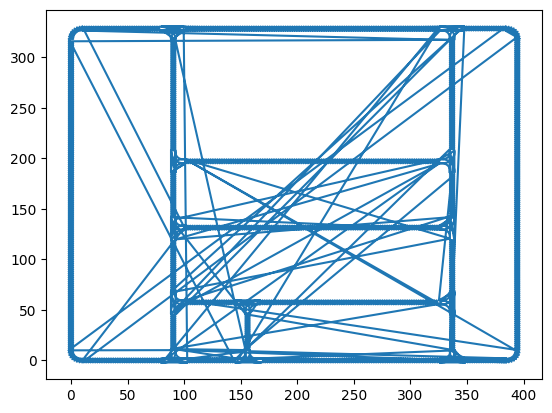

In [29]:
plt.plot(x,y)